# Navier-Stokes Equation  
The Navier-Stokes equations describes the physics of fluid dynamics and is used in many different fields from oceanography to aircraft wing design to pollution analysis and many more. This equation describes how temperature and density are related to the velocity and pressure fields of fluid in motion.

The equations are defined as:
  
$u_t+λ_1(uu_x+vu_y)+p_x−\lambda_2(u_{xx}+u_{yy})=0$  
$v_t+λ_1(uv_x+vv_y)+p_y−\lambda_2(v_{xx}+v_{yy})=0$  
  
$t\in[0,20]$; $x\in[1,8]$; $y\in[-2,2]$  
  
We will created a Physics Informed Neural Network (PINN) to solve these differential equations and for the given boundary conditions. Unlike the Burger's or Allen-Cahn PINNs, this model will utilize previously sampled data to help train the network.

## 1. Import Python Packages
This implementation will uses some common data science packages:
- <b>Pytorch:</b> package of machine learning tools, including user-friendly neural network functions
- <b>Pandas / Numpy</b>: collection of data reading and manipulation tools
- <b>Matplotlib</b>: package of data visualization tools
  
Additionally, this notebook supports CPU and GPU computing so the default device will be checked and used for processing

In [2]:
import time
import os
import scipy.io
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Looks to see if GPU is available, if not sets default to CPU. Allows the models to be trained/analyzed using different hardware
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Map Model and Data Directories
If the files are in the same folder as this notebook, these values can remain as just the file name

In [3]:
filepath_to_load_model = 'NS_model.pt' #<--- change to None (no parenthesis) if you want to start new
filepath_to_save_model = 'NS_model.pt' #<--- change to new file name if you do not want to overwrite the pretrained model
data_filepath = 'cylinder_nektar_wake.mat'

## 3. Read in Sample Data
Dataset provided for exact values of u(t,x,y), v(t,x,y), and p(t,x,y) sampled over various values of t, x, and y. A .mat file provides the values that must be extracted and reformatted for processing by the model. This data will be used to test the model output and compute the loss function. 

In [4]:
# Function reads in sample data from .mat file
# puts data in proper orientation for processing/training
def read_data(file):
    # read .mat file contents
    data = scipy.io.loadmat(file)
    
    # read data columns
    U_star = data['U_star']
    p_star = data['p_star']
    t_star = data['t']
    X_star = data['X_star']

    # get number of x and t values in list
    N = X_star.shape[0]
    T = t_star.shape[0]

    # extract data from column cells
    XX = np.tile(X_star[:, 0:1], (1, T))
    YY = np.tile(X_star[:, 1:2], (1, T))
    TT = np.tile(t_star, (1, N)).T
    
    UU = U_star[:, 0, :]
    VV = U_star[:, 1, :]
    pp = p_star
    
    # flatten data into appropriate dimension: (size, 1)
    x = XX.flatten()[:, None] # NT x 1
    y = YY.flatten()[:, None] # NT x 1
    t = TT.flatten()[:, None] # NT x 1

    u = UU.flatten()[:, None] # NT x 1
    v = VV.flatten()[:, None] # NT x 1
    p = pp.flatten()[:, None] # NT x 1

    # delete unnecessary variables to save RAM. May be necessary for GPU on limited RAM
    del data, U_star, p_star, t_star, X_star, N, T, XX, YY, TT, UU, VV, pp
    
    # return the input and output variables in proper format
    return x,y,t,u,v,p
    
    
# read in values from .mat file
x, y, t, u, v, p = read_data(data_filepath)

## 4. Define the Algorithm Architecture
Requirements: 3 inputs (t,x,y), 2 outputs ($\Psi$,p), and 2 constant values ($\lambda_1$,$\lambda_2$)  
  
The model can be created using any combination of valid hidden layers; however, the more complex the network, the more data and computational power is required to train the model. On the opposite side, if the network is too simplistic, it may not be able to learn the characteristics of the data.  
### This model was created using:
- Input layer (3 variables)
- 8 Hidden layers (20 neurons)
- Output layer (2 variables)

In [5]:
# Defines the network class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Placeholder for lambda constant values that will be learned by model 
        self.lambda_1 = nn.Parameter(torch.randn(1, requires_grad= True))
        self.lambda_2 = nn.Parameter(torch.randn(1, requires_grad= True))
        
        # Construct the neural network architecture
        # Using 3-variable input layer, 8X20 hidden layers, 2-variable output layer
        self.hidden_layer1 = nn.Linear(3,20)
        self.hidden_layer2 = nn.Linear(20,20)
        self.hidden_layer3 = nn.Linear(20,20)
        self.hidden_layer4 = nn.Linear(20,20)
        self.hidden_layer5 = nn.Linear(20,20)
        self.hidden_layer6 = nn.Linear(20,20)
        self.hidden_layer7 = nn.Linear(20,20)
        self.hidden_layer8 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,2)

    def forward(self, t,x,y):
        # Connects each of the layers together. Accepts 3 input parameters: t, x, y
        inputs = torch.cat([t,x,y],axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        layer6_out = torch.sigmoid(self.hidden_layer6(layer5_out))
        layer7_out = torch.sigmoid(self.hidden_layer7(layer6_out))
        layer8_out = torch.sigmoid(self.hidden_layer8(layer7_out))
        output = self.output_layer(layer8_out)
        return output
    
#initialize a new network
net = Net()

#map the network to the default device type (GPU/CPU)
net = net.to(device)

## 5. Define PDE functions  
We just defined a Neural Network (NN) to take inputs <b>t,x,y</b> and return $\hat{\Psi}$,$\hat{P}$. This can be represented as the following equation: 
  
$NN(t,x,y) = |\hat{\Psi}, \hat{p}|$  
  
where;
  
$\hat{u}(t,x,y)=\hat{\Psi}_y$  
$\hat{v}(t,x,y)=-\hat{\Psi}_x$  
  
Therefore, the NN outputs must satisfy the Navier-Stokes PDEs as shown below:
  
$\hat{u}_t+λ_1(\hat{u}\hat{u}_x+\hat{v}\hat{u}_y)+\hat{p}_x−\lambda_2(\hat{u}_{xx}+\hat{u}_{yy})=0$  
$\hat{v}_t+λ_1(\hat{u}\hat{v}_x+\hat{v}\hat{v}_y)+\hat{p}_y−\lambda_2(\hat{v}_{xx}+\hat{v}_{yy})=0$  
  
To satisfy these equations, the model output must be decomposed to get the variables $\hat{u}$, $\hat{v}$, and $\hat{p}$ along with the first and second order derivatives that are required in the above equations. The resulting functions can then be inputted into the PDEs for calculation. For loss function testing, this function will return the two PDE results along with the functions of $\hat{u}$, $\hat{v}$, and $\hat{p}$ for comparison to the sampled data

In [6]:
# Function to deconstruct output variables and define PDEs to solve
def f(t, x, y, net):
    # get current working lambda values
    lambda1 = net.lambda_1
    lambda2 = net.lambda_2

    # predict results given input values for t,x,y
    psi_p = net(t, x, y)
    
    # model outputs 2 variables. Assign first output to Psi(t,x,y), second to P(t,x,y)
    psi = psi_p[:, 0].reshape(-1,1)
    p = psi_p[:, 1].reshape(-1,1)
    
    # decompose velcoty function
    # calculate u(t,x,y) = dPsi/dy and v(t,x,y) = -dPsi/dx
    u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    
    # calculate first order derivatives for PDE
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    
    v_t = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    
    p_x = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
    p_y = torch.autograd.grad(p.sum(), y, create_graph=True)[0]

    # calculate second order derivatives for PDE
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y.sum(), y, create_graph=True)[0]

    # calculate PDEs
    f_u = u_t + lambda1*(u*u_x + v*u_y) + p_x - lambda2*(u_xx + u_yy)
    f_v = v_t + lambda1*(u*v_x + v*v_y) + p_y - lambda2*(v_xx + v_yy)

    # delete unnecessary variables to save RAM. May be necessary for GPU on limited RAM
    del lambda1, lambda2, psi_p, psi, u_t, u_x, u_y, v_t, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y
    
    # return functions of velocity, pressure and PDE results
    return u, v, p, f_u, f_v

# define default loss function as the mean squared error
mse_cost_function = torch.nn.MSELoss()

# define the optimizer function
optimizer = torch.optim.Adam(net.parameters())

## 6. Train the Model
This model will be trained over <i><b>n</b></i> number of iterations with a batch size of <i><b>x</b></i> randomly chosen data points. Both of these values can be adjusted for better training performance.  
  
To train the model, the optimizer will attempt to reduce the model loss down to zero. Therfore, the loss function must be defined to incorporate the information gained by attempting to solve the PDEs and the error between the output values and the sampled exact values.  
  
To calculate the loss, Mean Squared Error (MSE) will be used on the model outputs.: 
  
$MSE = \frac{1}{N} \sum{(Value_{actual} – Value_{predicted})^2}$  
  
Recalling from steps 3 and 5, we have two PDEs that have been defined along with the model outputs and the associated exact values. When calculating the loss, the function should be created in a way where the best loss value will be 0. In order to achieve this for our model, the predicted values can be compared with the exact values to get the error between the two. Additionally, since the PDEs are supposed to equal zero, this error can be used to calculate the loss as well. Each of these components results in a loss function of:  
  
$MSE_{outputs} = \frac{1}{N} \sum{(|u – \hat{u}|^2 + |v – \hat{v}|^2 + |p – \hat{p}|^2)}$  
  
$MSE_{PDEs} = \frac{1}{N} \sum{(|PDE_u| + |PDE_v|)}$ 
  
$Loss = MSE_{outputs} + MSE_{PDEs}$  
  
For each iteration of training, this loss function will be calculated and the result will be used by the optimizer to adjust the neural network. Graphing the loss function over time should result in an exponentially decreasing function that converges towards zero.

1000 Training Loss: 0.15573
2000 Training Loss: 0.11585
3000 Training Loss: 0.11418
4000 Training Loss: 0.12025
5000 Training Loss: 0.11093
Completed 5000 iterations in 6.0 minutes


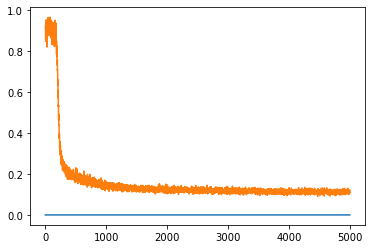

In [6]:
# set number of iterations desired for training
iterations = 5000

losses = []
start = time.time()

# load the current working version of the model
# Allows training to resume from last saved model
# Comment out line if no model has been created yet
if filepath_to_load_model is not None:
    net.load_state_dict(torch.load(filepath_to_load_model,map_location=device))

# for the number of iterations defined
for epoch in range(iterations):
    # clear the optimizer for new input
    optimizer.zero_grad()
    
    # identify the batch size (number of training points per iteration)
    N_train = 200
    
    # randomly sample data to match batch size
    idx = np.random.choice(len(x), N_train, replace=False)
    x_train = x[idx,:]
    y_train = y[idx,:]
    t_train = t[idx,:]
    u_train = u[idx,:]
    v_train = v[idx,:]
    p_train = p[idx,:]
    
    # define zeros as same length as batch size
    # will be used to calculate MSE
    zeros = np.zeros((N_train,1))

    # convert training date to tensor format
    pt_x = Variable(torch.from_numpy(x_train).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t_train).float(), requires_grad=True).to(device)
    pt_y = Variable(torch.from_numpy(y_train).float(), requires_grad=True).to(device)
    pt_u = Variable(torch.from_numpy(u_train).float(), requires_grad=True).to(device)
    pt_v = Variable(torch.from_numpy(v_train).float(), requires_grad=True).to(device)
    pt_p = Variable(torch.from_numpy(p_train).float(), requires_grad=True).to(device)
    pt_zeros = Variable(torch.from_numpy(zeros).float(), requires_grad=True).to(device)

    # delete unnecessary variables to save RAM. May be necessary for GPU on limited RAM
    del x_train, y_train, t_train, u_train, v_train, p_train, zeros
    
    # get output from model given the input parameters 
    u_hat, v_hat, p_hat, f_u, f_v = f(pt_t, pt_x, pt_y, net)

    
    # calculate error between predicted outputs (u_hat,v_hat,p_hat) and exact solutions (u,v,p)
    mse_u = mse_cost_function(u_hat, pt_u)
    mse_v = mse_cost_function(v_hat, pt_v)
    mse_p = mse_cost_function(p_hat, pt_p)
    
    # calculates error in PDE function
    # functions should equal 0 so mse calculated between 0 and PDE results (f_u, f_v)
    mse_f_u = mse_cost_function(f_u, pt_zeros)
    mse_f_v = mse_cost_function(f_v, pt_zeros)
    
    # sum all calculated error to get loss
    loss = mse_u + mse_v + mse_p + mse_f_u + mse_f_v
    
    # delete unnecessary variables to save RAM. May be necessary for GPU on limited RAM
    del u_hat, v_hat, p_hat, f_u, f_v, mse_u, mse_v, mse_p, mse_f_u, mse_f_v

    # use back propogation to pass the resulting loss backwards through the model
    # optimizer attempts to reduce the loss to zero
    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
        # adds the current loss to a list for future analysis/graphing
        losses.append(float(loss.data))

        # prints out status update every n iteration
        if (epoch+1)%1000 == 0:
            print(epoch+1,"Training Loss:",round(float(loss.data),5))
            
            # saves current working copy of model in case of crash
            torch.save(net.state_dict(), filepath_to_save_model)
    
    
# save final trained model
torch.save(net.state_dict(), filepath_to_save_model)

# print completion message
print('Completed',epoch+1,'iterations in',round((time.time()-start)/60,0), 'minutes')

# show graph of loss over training iterations
xs = list(range(len(losses)))
ys = np.zeros((len(losses),1))
plt.plot(xs,ys)
plt.plot(xs,losses)
plt.show()

## 8. Analyzing the Results
Overall performance of the model can be evaluated using the known sample data and the models outputs. Loss between the outputted functions can be calculated and used to track accuracy. Model performance can also be visualized by graphing the predicted functions against the exact values. Unfortunately, since this function operates in larger than 3 dimension, data must be visualized by keep some input values constant. 


Mean Squared Error: 0.0001015


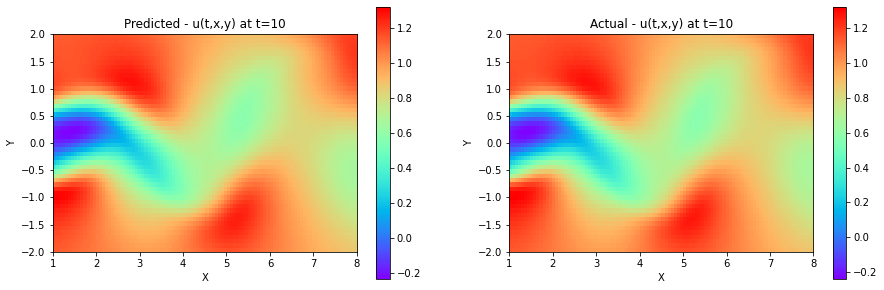

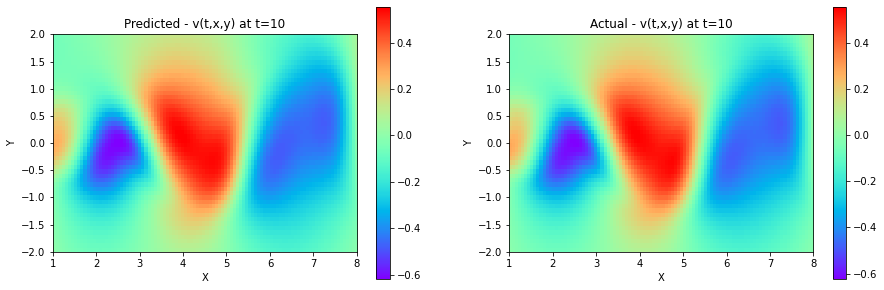

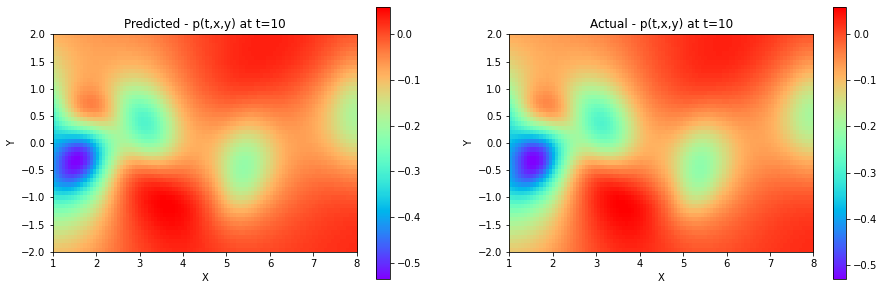

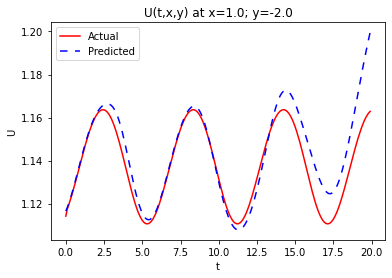

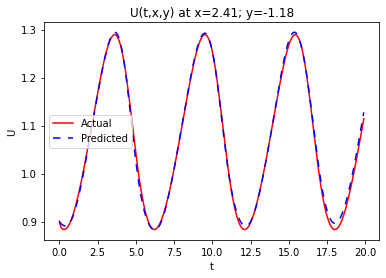

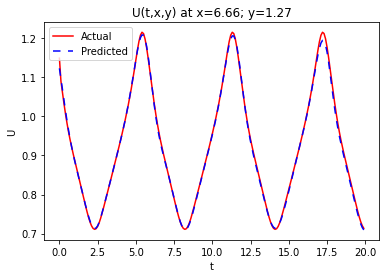

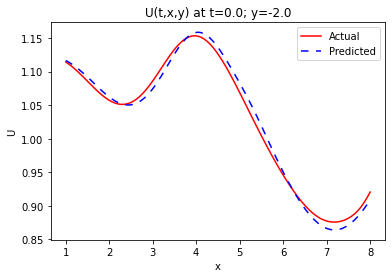

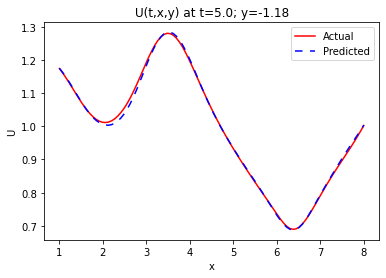

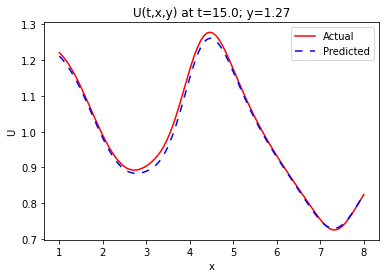

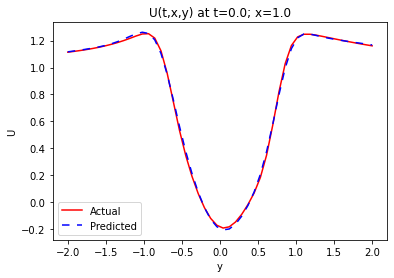

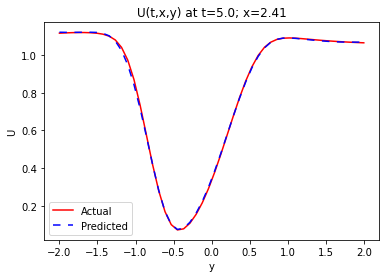

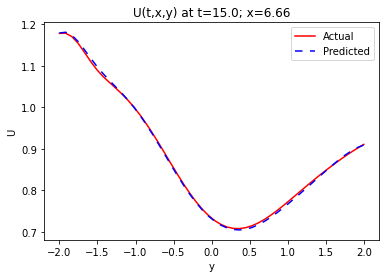

In [10]:
# loads trained model for analysis
net = Net()
net.load_state_dict(torch.load(filepath_to_save_model,map_location=device))

# Function tests the results of the model with the exact results
def test_result(x,y,t,u,v,p):
    # number of points to test
    N_test = 10000
    
    # ensures the random values are the same every time for comparison of model progress over time
    # comment line out if truly random samples are required
    np.random.seed(1234)
    
    # get random data points to match number of test points 
    idx = np.random.choice(len(x), N_test, replace=False)
    x_test = x[idx,:]
    y_test = y[idx,:]
    t_test = t[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]

    # convert variables to tensors for input into the model
    pt_x = Variable(torch.from_numpy(x_test).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t_test).float(), requires_grad=True).to(device)
    pt_y = Variable(torch.from_numpy(y_test).float(), requires_grad=True).to(device)
    pt_u = Variable(torch.from_numpy(u_test).float(), requires_grad=True).to(device)
    pt_v = Variable(torch.from_numpy(v_test).float(), requires_grad=True).to(device)
    pt_p = Variable(torch.from_numpy(p_test).float(), requires_grad=True).to(device)

    # Get resulting outputs from model given inputs (t,x,y)
    u_hat, v_hat, p_hat, f_u, f_v = f(pt_t, pt_x, pt_y, net)
    
    # calculate error of predicted values vs actual values for: u, v, p
    error = mse_cost_function(u_hat, pt_u)
    error += mse_cost_function(v_hat, pt_v)
    error += mse_cost_function(p_hat, pt_p)
    
    # print resulting error rate of model
    print('\nMean Squared Error:', round(float(error),7))
    
    
# function creates 2D heat map at constant time
def plot_heat_map(t_value, net):
    # read the exact data
    x, y, t, u, v, p = read_data(data_filepath)
    
    # get the values at the constant t value
    idx = np.where(t==t_value)[0]
    
    x = np.unique(x)
    y = np.unique(y)
    u_star = u[idx]
    v_star = v[idx]
    p_star = p[idx]
    
    # orient values in proper format for processing
    ms_x, ms_y = np.meshgrid(x, y)
    xx = np.ravel(ms_x).reshape(-1,1)
    yy = np.ravel(ms_y).reshape(-1,1)
    
    # assign all t values to inputted constant
    tt = np.ones((len(xx),1))*t_value
    
    # convert values to tensors for model input
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_y = Variable(torch.from_numpy(yy).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(tt).float(), requires_grad=True).to(device)
    
    # get model output given input values 
    u_hat, v_hat, p_hat, f_u, f_v = f(pt_t, pt_x, pt_y, net)
    
    # arrange the output variables in 2D array for graphing
    u=np.asarray(u_hat.data)
    u=u.reshape(ms_x.shape)
    v=np.asarray(v_hat.data)
    v=v.reshape(ms_x.shape)
    p=np.asarray(p_hat.data)
    p=p.reshape(ms_x.shape)
    u_star = u_star.reshape(ms_x.shape)
    v_star = v_star.reshape(ms_x.shape)
    p_star = p_star.reshape(ms_x.shape)
    
    
    fig = plt.figure(figsize=(15,5))
    # plots the 2D array for predicted u(t,x,y)
    plt.subplot(1, 2, 1)
    plt.imshow(u, cmap='rainbow', interpolation='nearest', aspect=1.25, extent=[1,8,-2,2])
    plt.title("Predicted - u(t,x,y) at t="+str(t_value))
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.colorbar()
    
    # plots the 2D array for actual u(t,x,y)
    plt.subplot(1, 2, 2)
    plt.imshow(u_star, cmap='rainbow', interpolation='nearest', aspect=1.25, extent=[1,8,-2,2])
    plt.title("Actual - u(t,x,y) at t="+str(t_value))
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.colorbar()
    
    plt.show()
    
    
    fig = plt.figure(figsize=(15,5))
    # plots the 2D array for predicted v(t,x,y)
    plt.subplot(1, 2, 1)
    plt.imshow(v, cmap='rainbow', interpolation='nearest', aspect=1.25, extent=[1,8,-2,2])
    plt.title("Predicted - v(t,x,y) at t="+str(t_value))
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.colorbar()
    
    # plots the 2D array for actual v(t,x,y)
    plt.subplot(1, 2, 2)
    plt.imshow(v_star, cmap='rainbow', interpolation='nearest', aspect=1.25, extent=[1,8,-2,2])
    plt.title("Actual - v(t,x,y) at t="+str(t_value))
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.colorbar()
    
    plt.show()
    
    
    fig = plt.figure(figsize=(15,5))
    # plots the 2D array for predicted p(t,x,y)
    plt.subplot(1, 2, 1)
    plt.imshow(p, cmap='rainbow', interpolation='nearest', aspect=1.25, extent=[1,8,-2,2])
    plt.title("Predicted - p(t,x,y) at t="+str(t_value))
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.colorbar()
    
    # plots the 2D array for actual p(t,x,y)
    plt.subplot(1, 2, 2)
    plt.imshow(p_star, cmap='rainbow', interpolation='nearest', aspect=1.25, extent=[1,8,-2,2])
    plt.title("Actual - p(t,x,y) at t="+str(t_value))
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.colorbar()
    
    plt.show()
    
    
# Function compares the predicted u(t,x,y) results to exact at constant t and y values
def plot_x_value(t_value, y_value, net):
    # read the exact data
    x, y, t, u, v, p = read_data(data_filepath)
    
    # get the x and u values at the constant t and y values
    idx = np.where((t==t_value) & (y==y_value))
    x = x[idx]
    xx = x.reshape(-1,1)
    u_star = u[idx]
    uu = u_star.reshape(-1,1)
    
    # set the t and y values to their constant values 
    tt = np.ones((len(xx),1))*t_value
    yy = np.ones((len(xx),1))*y_value
    
    # convert the values to tensors for model input 
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_y = Variable(torch.from_numpy(yy).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(tt).float(), requires_grad=True).to(device)
    
    # get the model output for the given inputs 
    u_hat, v_hat, p_hat, f_u, f_v = f(pt_t, pt_x, pt_y, net)
    u=np.asarray(u_hat.data)
    
    # plot the exact u(t,x,y) as red line
    plt.plot(x,u_star,'red', label='Actual')
    
    # plot the predicted u(t,x,y) as dotten blue line
    plt.plot(x,u,'blue', linestyle=(0,(5,5)), label='Predicted')
    plt.title('U(t,x,y) at t='+str(round(t_value,2))+'; y='+str(round(y_value,2)))
    plt.ylabel('U')
    plt.xlabel('x')
    plt.legend()
    plt.show()
    
    
# Function compares the predicted u(t,x,y) results to exact at constant t and x values
def plot_y_value(t_value, x_value, net):
    # read the exact data
    x, y, t, u, v, p = read_data(data_filepath)
    
    # get the y and u values at the constant t and x values
    idx = np.where((t==t_value) & (x==x_value))
    y = y[idx]
    yy = y.reshape(-1,1)
    u_star = u[idx]
    uu = u_star.reshape(-1,1)
    
    # set the t and x values to their constant values
    tt = np.ones((len(yy),1))*t_value
    xx = np.ones((len(yy),1))*x_value
    
    # convert the values to tensors for model input 
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_y = Variable(torch.from_numpy(yy).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(tt).float(), requires_grad=True).to(device)
    
    # get the model output for the given inputs 
    u_hat, v_hat, p_hat, f_u, f_v = f(pt_t, pt_x, pt_y, net)
    u=np.asarray(u_hat.data)
    
    # plot the exact u(t,x,y) as red line
    plt.plot(y,u_star,'red', label='Actual')
    
    # plot the predicted u(t,x,y) as dotten blue line
    plt.plot(y,u,'blue', linestyle=(0,(5,5)), label='Predicted')
    plt.title('U(t,x,y) at t='+str(round(t_value,2))+'; x='+str(round(x_value,2)))
    plt.ylabel('U')
    plt.xlabel('y')
    plt.legend()
    plt.show()
    
    
# Function compares the predicted u(t,x,y) results to exact at constant x and y values    
def plot_t_value(x_value, y_value, net):
    # read the exact data
    x, y, t, u, v, p = read_data(data_filepath)
    
    # get the t and u values at the constant x and y values
    idx = np.where((x==x_value) & (y==y_value))
    t = t[idx]
    tt = t.reshape(-1,1)
    u_star = u[idx]
    uu = u_star.reshape(-1,1)
    
    # set the x and y values to their constant values
    xx = np.ones((len(tt),1))*x_value
    yy = np.ones((len(tt),1))*y_value
    
    # convert the values to tensors for model input
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_y = Variable(torch.from_numpy(yy).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(tt).float(), requires_grad=True).to(device)
    
    # get the model output for the given inputs 
    u_hat, v_hat, p_hat, f_u, f_v = f(pt_t, pt_x, pt_y, net)
    u=np.asarray(u_hat.data)
    
    # plot the exact u(t,x,y) as red line
    plt.plot(t,u_star,'red', label='Actual')
    
    # plot the predicted u(t,x,y) as dotten blue line
    plt.plot(t,u,'blue', linestyle=(0,(5,5)), label='Predicted')
    plt.title('U(t,x,y) at x='+str(round(x_value,2))+'; y='+str(round(y_value,2)))
    plt.ylabel('U')
    plt.xlabel('t')
    plt.legend()
    plt.show()

    

#test the performance of the saved model
test_result(x,y,t,u,v,p)

#plot the heat maps for u(t,x,y), v(t,x,y) and p(t,x,y)
plot_heat_map(10, net)

# get the values of x, y, and t in the sample data
x_vals = np.unique(x)
y_vals = np.unique(y)
t_vals = np.unique(t)

# plot u(t,x,y) at constant x,y values 
plot_t_value(x_vals[0],y_vals[0],net)
plot_t_value(x_vals[20],y_vals[10],net)
plot_t_value(x_vals[80],y_vals[40],net)

# plot u(t,x,y) at constant t,y values 
plot_x_value(t_vals[0],y_vals[0],net)
plot_x_value(t_vals[50],y_vals[10],net)
plot_x_value(t_vals[150],y_vals[40],net)

# plot u(t,x,y) at constant t,x values 
plot_y_value(t_vals[0],x_vals[0],net)
plot_y_value(t_vals[50],x_vals[20],net)
plot_y_value(t_vals[150],x_vals[80],net)